## Requirements

In [77]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install httpx==0.27.2

In [78]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent
from langchain.prompts import BasePromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.agents.agent import Agent
from langchain.prompts import BasePromptTemplate
from langchain.schema import AgentAction, AgentFinish
from typing import List, Union, Any, Dict, Optional

from IPython.display import Image, display
from IPython.display import display, Markdown

import requests
import locale
import requests
import json
import os

from google.colab import drive

In [79]:
locale.getpreferredencoding = lambda: "UTF-8"

drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
os.environ['TAVILY_API_KEY'] = "TAVILY_API_KEY"
os.environ['OPENAI_API_KEY'] = "OPENAI_API_KEY"
WEATHER_API_KEY = "WEATHER_API_KEY"

In [81]:
tv_search = TavilySearchResults(max_results=3, search_depth='advanced', max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

In [82]:
chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [search_web, get_weather]

chatgpt_with_tools = chatgpt.bind_tools(tools)

In [83]:
SYS_PROMPT = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                  - get_weather: whenever user asks get the weather of a place.
                  - search_web: whenever user asks for information on current events or if you don't know the answer.
             """

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="messages")
    ]
)

def add_sys_prompt(messages):
    return prompt_template.invoke({"messages": messages}).to_messages()

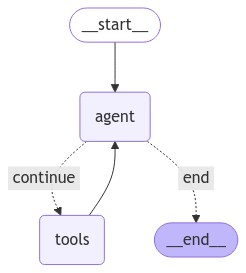

In [84]:
agent = create_react_agent(chatgpt, tools, messages_modifier = add_sys_prompt)
display(Image(agent.get_graph().draw_mermaid_png()))

In [85]:
query = """Tell me who won the ICC Men's Cricket World Cup in 2024, show some detailed information about the match also"""
response = chatgpt.invoke(query)
response.content

"I'm sorry, but I don't have information on events that occur after October 2023, including the ICC Men's Cricket World Cup in 2024. You might want to check the latest updates from reliable sports news sources or the official ICC website for the most current information."

In [86]:
query = """Tell me who won the ICC Men's Cricket World Cup in 2024, show some detailed information about the match also"""
response = agent.invoke({"messages": [('user', query)]})
display(Markdown(response['messages'][-1].content))

India won the ICC Men's T20 World Cup in 2024. They defeated South Africa by seven runs in the final match held at the Kensington Oval in Bridgetown, Barbados, on June 29, 2024.

### Match Details:
- **Final Match**: India vs. South Africa
- **Venue**: Kensington Oval, Bridgetown, Barbados
- **Date**: June 29, 2024
- **Result**: India won by 7 runs

### Highlights:
- India ended their title drought with this victory.
- Jasprit Bumrah was a standout performer, playing a crucial role in India's win.
- The match was a thrilling contest, with India managing to hold off South Africa's chase.

For more detailed information, you can check the [Cricket World](https://www.cricketworld.com/icc-mens-t20-world-cup-2024-final-south-africa-vs-india-kohli-leads-the-way-as-india-win-t20-world-cup-by-7-runs/95362.htm) article.

In [87]:
query = """how is the weather in Bloomington, Indiana today?
        """
response = agent.invoke({"messages": [('user', query)]})
display(Markdown(response['messages'][-1].content))

The weather in Bloomington, Indiana today is partly cloudy with a temperature of -3.9°C (25.0°F). The wind is coming from the west-northwest at 13.4 mph (21.6 kph), making it feel like -10.4°C (13.2°F). The humidity is at 58%, and there is no precipitation. Visibility is good at 16 km (9 miles), and the UV index is low at 1.2.

## Build and Test Multi-User Conversational AI Agent

We will now use `SQLChatMessageHistory` which we learnt in the previous module to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time

In [88]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

In [89]:
# used to retrieve conversation history from database
# based on a specific user or session ID
memory = SqliteSaver.from_conn_string("memory.db")

# create a conversation chain + agent which can load memory based on specific user or session id
agentic_chatbot = create_react_agent(chatgpt, tools = tools, checkpointer = memory, messages_modifier = add_sys_prompt)

# function to call the agent show results per user session
def chat_with_agent(prompt: str, session_id: str):
    response = agentic_chatbot.invoke({"messages": [("user", prompt)]},
                                      {'configurable': { 'session_id': session_id, 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

In [90]:
user_id = 'rishett'
prompt = "Tell me who won ICC Men's Cricket World Cup in 2024. Talk about this event in detail."
chat_with_agent(prompt, user_id)

The ICC Men's T20 World Cup 2024 was won by India. The final match took place at the Kensington Oval, where India faced South Africa in a thrilling contest. India emerged victorious by seven runs, ending their title drought and marking a significant achievement in their cricketing history.

In the final, India set a target of 176/7, thanks to a crucial innings by Virat Kohli, who scored a fighting 76 runs. The match was intense and closely contested, but India's bowlers managed to hold their nerve and restrict South Africa, securing the win.

This victory was particularly significant for India as it came after a narrow loss in the 50-over World Cup final the previous year. The win in the T20 World Cup 2024 highlighted India's dominance in the shorter format of the game and was celebrated by cricket fans around the world.

In [91]:
user_id = 'aksak'
prompt = "how is the weather in Indianapolis today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The current weather in Indianapolis, Indiana is as follows:

- **Temperature**: -7.2°C (19.0°F)
- **Condition**: Partly cloudy
- **Wind**: 13.9 mph (22.3 kph) from the WNW
- **Wind Gusts**: Up to 17.4 mph (28.0 kph)
- **Humidity**: 62%
- **Pressure**: 1025.0 mb (30.28 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 50%
- **Visibility**: 16.0 km (9.0 miles)
- **UV Index**: 1.0 (Low)
- **Feels Like**: -14.7°C (5.5°F)
- **Wind Chill**: -12.5°C (9.4°F)
- **Dew Point**: -7.9°C (17.8°F)

The weather is cold with a significant wind chill, so it's advisable to dress warmly if you're heading outside.

In [92]:
user_id = 'rishett'
prompt = "what about the weather in San Jose?"
chat_with_agent(prompt, user_id)

The current weather in San Jose, California, is partly cloudy with a temperature of 15.6°C (60.1°F). The wind is blowing from the north-northwest at 2.2 mph (3.6 kph), and the humidity is at 32%. There is no precipitation at the moment, and the visibility is good at 16 km (9 miles). The UV index is 2.3, indicating low exposure.

In [93]:
user_id = 'aksak'
prompt = "which city is hotter among the two?"
chat_with_agent(prompt, user_id)

To determine which city is hotter, I need to know the second city you are comparing with Indianapolis. Could you please provide the name of the other city?

In [94]:
user_id = 'aksak'
prompt = "what about San Jose?"
chat_with_agent(prompt, user_id)

Currently, San Jose, California is significantly warmer than Indianapolis, Indiana.

- **San Jose Temperature**: 15.6°C (60.1°F)
- **Indianapolis Temperature**: -7.2°C (19.0°F)

San Jose is experiencing a mild and pleasant temperature, while Indianapolis is much colder.